<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/ECL/ECLLimitLevel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings

from pandas.core.common import SettingWithCopyWarning

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style
warnings.simplefilter(action = 'ignore', category = SettingWithCopyWarning) #Off warning

In [3]:
# Import data
df = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/ECL/datasets/ECLLimitData.csv',
    dtype = {
        'LimitID': str,
        'AccountID': str
    }
)

# Show table
df.head(5)

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage
0,31/12/2022,999999999999941,611267004,TL,574225.24,167028.16,10443.93,6.58,1
1,31/12/2022,999999999999941,611267005,RP,574225.24,83661.58,NaN,9.06,1
2,31/12/2022,999999999999941,611267006,RP,574225.24,18832.65,NaN,7.34,1
3,31/12/2022,999999999999941,611267007,TL,574225.24,56400.00,3460.97,5.23,1
4,31/12/2022,999999999999941,611267008,TL,574225.24,24890.00,1346.45,5.26,1


In [4]:
# Define next balance function
def balances(rate, payment, os):
  interestAmount = os * rate / 100 / 12
  nextBalance = os + interestAmount - payment
  return round(nextBalance, 2)

In [5]:
# Define amortization function
def AMT(inputData):
  # Get amortization parameters
  rate = inputData['EIR'].values[0]
  payment = inputData['Installment'].values[0]
  amount = inputData['Outstanding'].values[0]
  amortization = [amount] #First oustanding
  if amount - payment < 0:
    inputData['DiscountTime'] = 1
    schedule.append(inputData)
    pass
  else:
    while amount > 0:
      amount = balances(rate, payment, amount)
      amortization.append(amount)
    if amortization[-1] <= 0:
      amortization.pop(-1) #Remove last value
    # To DataFrame
    scheduleTable = pd.DataFrame(
        np.repeat(
            inputData.values,
            len(amortization),
            axis = 0
        ),
        columns = inputData.columns
    )
    scheduleTable['Outstanding'] = amortization
    scheduleTable['DiscountTime'] = scheduleTable.index + 1
  return scheduleTable

In [6]:
# Define plot function
def plotEAD(data, stage, CCF):
  plt.figure(figsize = (10, 6))
  plt.plot(
      data['DiscountTime'],
      data['Outstanding'],
      color = 'green',
      linestyle = '--',
      label = 'Amortization'
  )
  plt.bar(
      data['DiscountTime'],
      data['AvailableLimit'],
      color = 'gray',
      width = 0.9,
      label = 'Undrawn portion'
  )
  plt.bar(
      data['DiscountTime'],
      data['AvailableLimit'] * CCF,
      color = 'orange',
      width = 0.9,
      label = 'Drawn portion'
  )
  plt.plot(
      data['DiscountTime'],
      data['AvailableLimit'] * CCF + data['Outstanding'],
      color = 'red',
      linewidth = 3,
      label = 'EAD with drawn portion'
  )
  plt.xticks(
      range(data['DiscountTime'].min(), data['DiscountTime'].max() + 1, 1)
  )
  plt.title(f'EAD with avaialble limit stage {stage}')
  plt.xlabel('Month after reporting date')
  plt.ylabel('Amount')
  plt.legend(frameon = True, facecolor = 'white', loc = 1)
  return plt.show()

In [7]:
# Amortization schedule
ECL = []

for limit in df['LimitID'].unique():
  # Get loan data
  loanData = df.query(
      "LimitID == @limit"
  )
  stage = loanData['Stage'].max() #Limit stage
  limitAvailiable = loanData['Limit'].max() - loanData['Outstanding'].sum() #Available limit amount

  # ECL for stage 3
  if stage == 3:
    scheduleLimit = loanData.groupby(
      ['AsOfDate', 'LimitID', 'Limit', 'Stage'],
      as_index = False
    ).agg(
        {
          'Outstanding': lambda amount: amount.sum(),
          'Installment': lambda amount: amount.sum()
        }
    )
    scheduleLimit['EIR'] = np.average(
        loanData['EIR'],
        weights = loanData['Outstanding']
    ) #Assign weighted EIR
    scheduleLimit['DiscountTime'] = 1
    scheduleLimit['AvailableLimit'] = limitAvailiable #Available limit at limit level
    ECL.append(scheduleLimit)
    continue

  # Separate by loan type
  # Term loan
  schedule = []
  if 'TL' in loanData['LoanType'].unique():
    termLoan = loanData.query(
        "LoanType == 'TL'"
    )
    accountSchedule = []
    for account in termLoan['AccountID'].unique():
      # Get loan data on each account ID
      data = termLoan.query(
          "AccountID == @account"
      )
      scheduleTable = AMT(data) #Amortization
      accountSchedule.append(scheduleTable)
    accountSchedule = pd.concat(
        accountSchedule,
        axis = 0,
        ignore_index = True
    )
    # Aggregate term loan to limit level
    accountSchedule = accountSchedule.groupby(
        ['AsOfDate', 'LimitID', 'LoanType', 'Limit', 'Stage', 'DiscountTime'],
        as_index = False
    ).agg(
        {
            'Outstanding': lambda amount: amount.sum(),
            'Installment': lambda amount: amount.sum()
        }
    )
    accountSchedule['EIR'] = np.average(
        termLoan['EIR'],
        weights = termLoan['Outstanding']
    ) #Assign weighted EIR
    schedule.append(accountSchedule)

  # Revolving product
  if 'RP' in loanData['LoanType'].unique():
    revolvingProduct = loanData.query(
        "LoanType == 'RP'"
    )
    revolvingProduct['Installment'] = 0.05 * revolvingProduct['Outstanding'] #Minimum payment
    # Aggregate revolving product to limit level
    data = revolvingProduct.groupby(
        ['AsOfDate', 'LimitID', 'LoanType', 'Limit', 'Stage'],
        as_index = False
    ).agg(
        {
            'Outstanding': lambda amount: amount.sum(),
            'Installment': lambda amount: amount.sum(),
            'EIR': lambda rate: np.average(
                rate,
                weights = revolvingProduct['Outstanding']
            )
        }
    )
    scheduleTable = AMT(data) #Amortization
    schedule.append(scheduleTable)
  scheduleDraft = pd.concat(
      schedule,
      axis = 0,
      ignore_index = True
  )

  # Aggregate to limit level
  scheduleLimit = scheduleDraft.groupby(
      ['AsOfDate', 'LimitID', 'Limit', 'Stage', 'DiscountTime'],
      as_index = False
  ).agg(
      {
          'Outstanding': lambda amount: amount.sum(),
          'Installment': lambda amount: amount.sum()
      }
  )
  scheduleLimit['EIR'] = np.average(
      scheduleDraft[scheduleDraft['DiscountTime'] == 1]['EIR'].values,
      weights = scheduleDraft[scheduleDraft['DiscountTime'] == 1]['Outstanding'].values
  ) #Assign weighted EIR
  # Available limit at limit level
  scheduleLimit['AvailableLimit'] = limitAvailiable + scheduleLimit['Installment'].cumsum().shift().fillna(0)
  scheduleLimit['AvailableLimit'] = scheduleLimit[['Limit', 'AvailableLimit']].min(axis = 1) #Capped miximum at limit amount
  
  # ECL for stage 1
  if stage == 1:
    scheduleLimit = scheduleLimit.query(
        "DiscountTime <= 12"
    )
    
  # Append result
  ECL.append(scheduleLimit)

In [8]:
# To DataFrame
ECL = pd.concat(
    ECL,
    axis = 0,
    ignore_index = True
)

# Show table
ECL.head(12)

,AsOfDate,LimitID,Limit,Stage,DiscountTime,Outstanding,Installment,EIR,AvailableLimit
0,31/12/2022,999999999999941,574225.24,1,1,350812.39,20376.0615,6.901536,223412.8500
1,31/12/2022,999999999999941,574225.24,1,2,332453.95,20376.0615,6.901536,243788.9115
2,31/12/2022,999999999999941,574225.24,1,3,313991.94,20376.0615,6.901536,264164.9730
3,31/12/2022,999999999999941,574225.24,1,4,295425.72,20376.0615,6.901536,284541.0345
4,31/12/2022,999999999999941,574225.24,1,5,276754.72,20376.0615,6.901536,304917.0960
5,31/12/2022,999999999999941,574225.24,1,6,257978.31,20376.0615,6.901536,325293.1575
6,31/12/2022,999999999999941,574225.24,1,7,239095.88,20376.0615,6.901536,345669.2190
7,31/12/2022,999999999999941,574225.24,1,8,220106.82,20376.0615,6.901536,366045.2805
8,31/12/2022,999999999999941,574225.24,1,9,201010.50,20376.0615,6.901536,386421.3420
9,31/12/2022,999999999999941,574225.24,1,10,181806.29,20376.0615,6.901536,406797.4035


In [9]:
# Show result
# Stage 1
ECL.query("Stage == 1").head(12) #LimitID = '999999999999941'

,AsOfDate,LimitID,Limit,Stage,DiscountTime,Outstanding,Installment,EIR,AvailableLimit
0,31/12/2022,999999999999941,574225.24,1,1,350812.39,20376.0615,6.901536,223412.8500
1,31/12/2022,999999999999941,574225.24,1,2,332453.95,20376.0615,6.901536,243788.9115
2,31/12/2022,999999999999941,574225.24,1,3,313991.94,20376.0615,6.901536,264164.9730
3,31/12/2022,999999999999941,574225.24,1,4,295425.72,20376.0615,6.901536,284541.0345
4,31/12/2022,999999999999941,574225.24,1,5,276754.72,20376.0615,6.901536,304917.0960
5,31/12/2022,999999999999941,574225.24,1,6,257978.31,20376.0615,6.901536,325293.1575
6,31/12/2022,999999999999941,574225.24,1,7,239095.88,20376.0615,6.901536,345669.2190
7,31/12/2022,999999999999941,574225.24,1,8,220106.82,20376.0615,6.901536,366045.2805
8,31/12/2022,999999999999941,574225.24,1,9,201010.50,20376.0615,6.901536,386421.3420
9,31/12/2022,999999999999941,574225.24,1,10,181806.29,20376.0615,6.901536,406797.4035


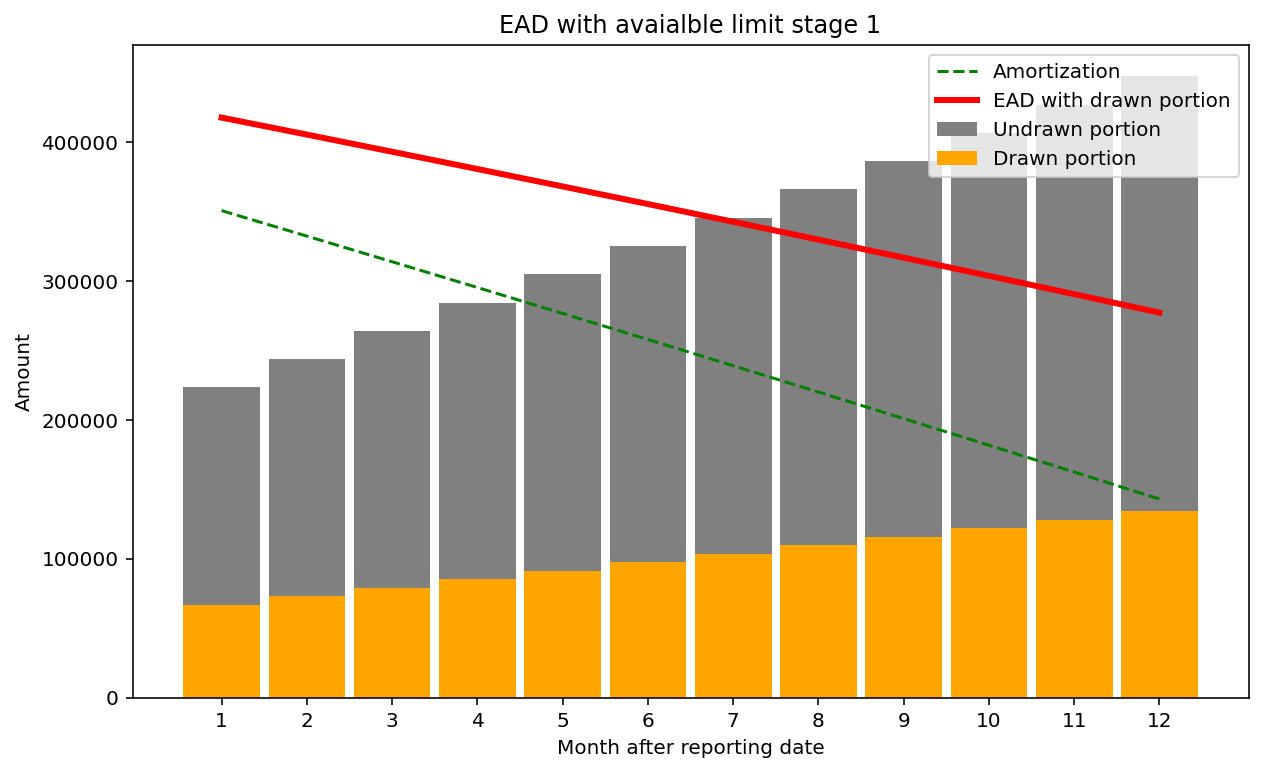

In [10]:
# Plot
dataPlot = ECL.query("LimitID == '999999999999941'")
plotEAD(dataPlot, 1, 0.3)

In [11]:
# Stage 2
ECL.query("Stage == 2").head(22) #LimitID = '999999999999979'

,AsOfDate,LimitID,Limit,Stage,DiscountTime,Outstanding,Installment,EIR,AvailableLimit
13,31/12/2022,999999999999979,743438.31,2,1,743438.31,44758.3866,5.319011,0.0000
14,31/12/2022,999999999999979,743438.31,2,2,701975.22,44758.3866,5.319011,44758.3866
15,31/12/2022,999999999999979,743438.31,2,3,660331.41,44758.3866,5.319011,89516.7732
16,31/12/2022,999999999999979,743438.31,2,4,618506.04,44758.3866,5.319011,134275.1598
17,31/12/2022,999999999999979,743438.31,2,5,582066.08,33782.6866,5.319011,179033.5464
18,31/12/2022,999999999999979,743438.31,2,6,550874.05,33782.6866,5.319011,212816.2330
19,31/12/2022,999999999999979,743438.31,2,7,519543.67,33782.6866,5.319011,246598.9196
20,31/12/2022,999999999999979,743438.31,2,8,488074.27,33782.6866,5.319011,280381.6062
21,31/12/2022,999999999999979,743438.31,2,9,456465.17,33782.6866,5.319011,314164.2928
22,31/12/2022,999999999999979,743438.31,2,10,424715.69,33782.6866,5.319011,347946.9794


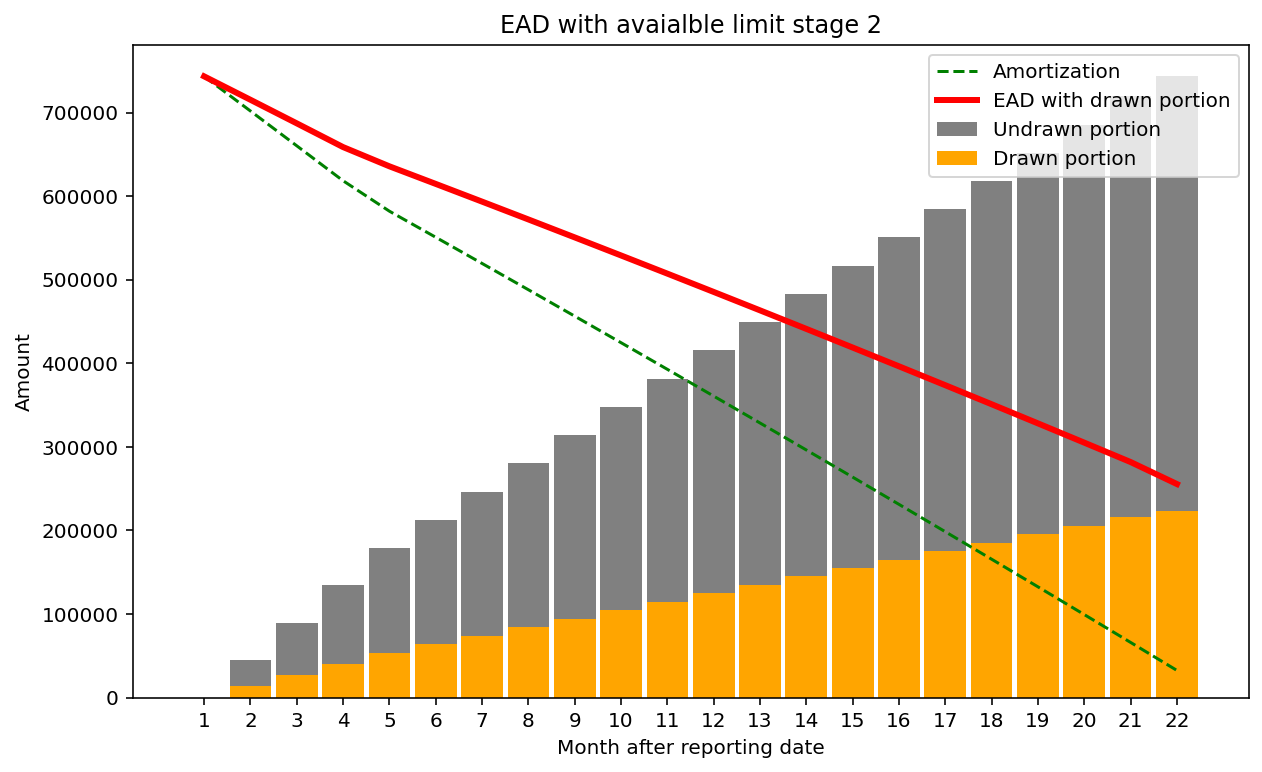

In [12]:
# Plot
dataPlot = ECL.query("LimitID == '999999999999979'")
plotEAD(dataPlot, 2, 0.3)

In [13]:
# Stage 3
ECL.query("Stage == 3") #LimitID = '999999999999948'

,AsOfDate,LimitID,Limit,Stage,DiscountTime,Outstanding,Installment,EIR,AvailableLimit
12,31/12/2022,999999999999948,441614.95,3,1,263202.28,17307.48,6.76062,178412.67


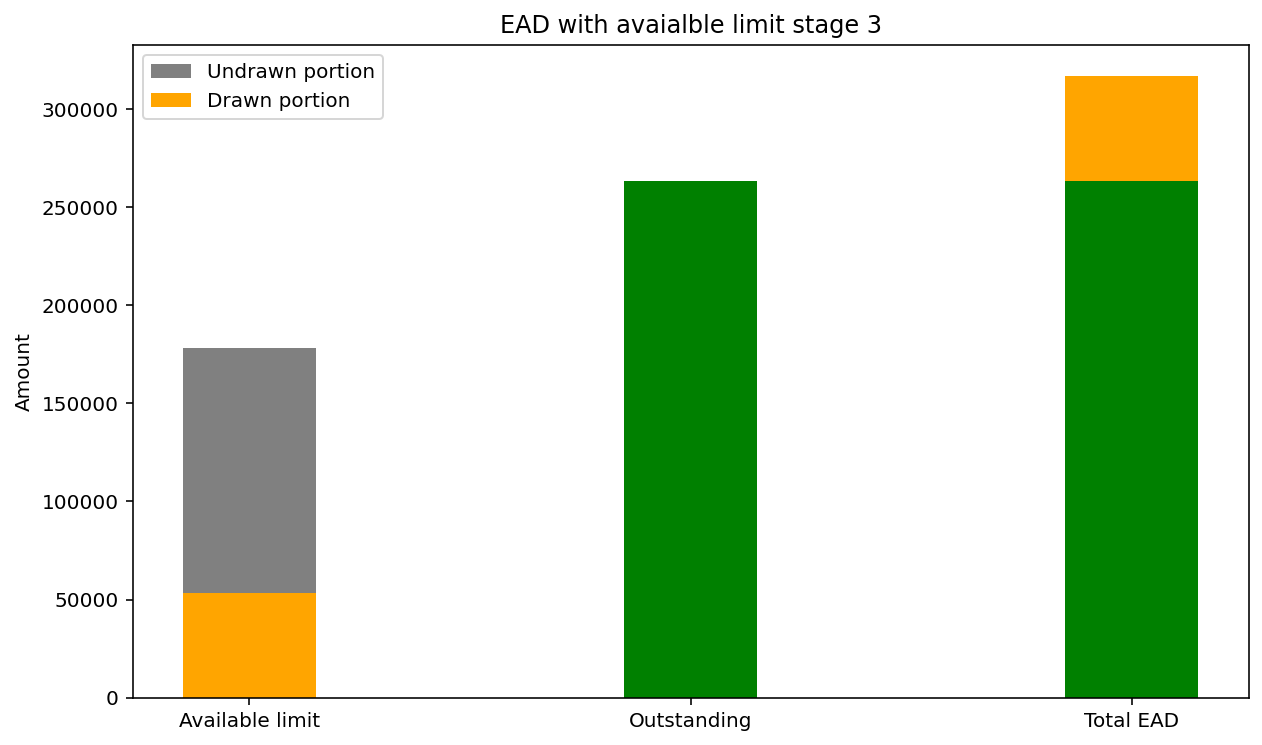

In [14]:
# Plot
dataPlot = ECL.query("LimitID == '999999999999948'")

plt.figure(figsize = (10, 6))
plotRange = ['Available limit', 'Outstanding', 'Total EAD']
plt.bar(
    plotRange[0],
    dataPlot['AvailableLimit'],
    color = 'gray',
    width = 0.3,
    label = 'Undrawn portion'
)
plt.bar(
    plotRange[0],
    dataPlot['AvailableLimit'] * 0.3,
    color = 'orange',
    width = 0.3,
    label = 'Drawn portion'
)
plt.bar(
    plotRange[1],
    dataPlot['Outstanding'],
    color = 'green',
    width = 0.3
)
plt.bar(
    plotRange[2],
    dataPlot['Outstanding'] + dataPlot['AvailableLimit'] * 0.3,
    color = 'orange',
    width = 0.3
)
plt.bar(
    plotRange[2],
    dataPlot['Outstanding'],
    color = 'green',
    width = 0.3
)
plt.title('EAD with avaialble limit stage 3')
plt.ylabel('Amount')
plt.legend(frameon = True, facecolor = 'white', loc = 0)
plt.show()